1. Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import make_scorer

2. Define functions to load data, create features

In [2]:
def create_features(df):
    df['Spread'] = df['High'] - df['Low']
    df['Gap'] = df['Open'] - df['Close'].shift(1)
    df['Intraday'] = df['Open'] - df['Close']
    return df

def drop_features(df):
    df.drop(columns=['Spread',
                     'Gap',
                     'Intraday',
                     ],
            inplace=True)

    df.drop(columns=['Open','High','Low','Close','Volume','Adj Close',
                     ], inplace=True)
    return df

def process_features(df, lookback, step):
    for i in range(step, lookback+1, step):
        df['%d Spread' % (i)] = df['Spread'].pct_change(periods=i, fill_method=None)
        df['%d Rolling Avg Spread' % (i)] = df['Spread'].rolling(window=i).mean()

        df['%d Gap' % (i)] = df['Gap'].pct_change(periods=i, fill_method=None)
        df['%d Rolling Avg Gap' % (i)] = df['Gap'].rolling(window=i).mean()

        df['%d Intraday' % (i)] = df['Intraday'].pct_change(periods=i, fill_method=None)
        df['%d Rolling Avg Intraday' % (i)] = df['Intraday'].rolling(window=i).mean()
    return df

def features(df, lookback, step):
    create_features(df)
    process_features(df, lookback, step)
    drop_features(df)
    return df

3. Create a function to create a target.

In [3]:
def create_target(df, lookforward=2, target='Open'):
    df['Target'] = np.log(df[target].shift(periods=-lookforward)/df[target].shift(periods=-1))
    return df

4. Create a custom scoring function.

In [4]:
def custom_score(y_true, y_pred):
  pred_sign = np.sign(y_pred)
  y_true = np.squeeze(y_true)
  returns = np.where((pred_sign == 1), y_true, 0)
  return returns.mean()

custom_scorer = make_scorer(custom_score, greater_is_better=True)

With this scoring function, we are scoring different models on their average returns, as opposed to the normal scoring function of a regression model, which would be R^2 or RMSE, both of which are fine if we were predicting price, but accurately predicting price =/= good returns. So instead we just score the models directly on their average returns.

5. Define the models we are going to use

In [5]:
estimator1 = Ridge()
estimator2 = Lasso(alpha=.001)
estimator3 = KNeighborsRegressor()
models = [estimator1,estimator2,estimator3]
estimator = VotingRegressor(estimators=[('Ridge', estimator1),
                                        ('Lasso', estimator2),
                                        ('KNN', estimator3),
                                        ])

We combine the 3 models into 1 using the VotingRegressor. The VotingRegressor works by averaging the output of the models that its composed of into a single output. Go to this link for more info: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html

6. Define target, cross validation folds, interval, and lookback parameters.

In [6]:
lookforward = 2
tscv = TimeSeriesSplit(n_splits=5, gap=lookforward)
steps = [1, 2, 3, 4, 5]
lookbacks = [1, 2, 3, 4, 5]
cv_results = pd.DataFrame(columns=['step', 'lookback', 'score'])

To make sure the strategy our models come up with are actually significant, and not just a memorization of the data we gave it, we test the model 5 times (n_splits=5). We also have to add a gap between each split, otherwise there will be some overlap, which could cause the models to peek at data it shouldn't, and artificially inflate its score. Next we define the steps (or intervals) and lookbacks we want to test our model at, in order to find the ones that it scores the highest on. Lastly, we create an object to store the results of our model in.

7. Evaluate and visualize scores of different combinations of parameters

In [16]:
for step in steps:
    for lookback in lookbacks:
        if lookback >= step:
            spy = yf.download('SPY', start='2004-01-01')
            agg = yf.download('AGG', start='2004-01-01')

            spy = create_target(spy, lookforward, target='Open')

            spy = features(spy, lookback, step)
            spy = spy.add_suffix(' SPY')
            agg = features(agg, lookback, step)
            agg = agg.add_suffix(' AGG')
            cv = pd.merge(spy, agg, how='inner', on='Date')

            cv.drop(cv.tail(lookforward).index, inplace=True)
            cv.drop(cv.head(lookback).index, inplace=True)
            X = cv
            y = X[['Target SPY']]
            X = X.drop(columns=['Target SPY'])
            X.fillna(method="ffill", inplace=True)
            X.replace([np.inf, -np.inf], 0, inplace=True)
            X.fillna(0, inplace=True)

            cv_score = cross_val_score(estimator=estimator, X=X, y=y,
                                       scoring=custom_scorer,
                                       cv=tscv, verbose=0)

            # cv_results = cv_results.append({'step': step, 'lookback': lookback, 'score': cv_score.mean()}, ignore_index=True)
            add_data = pd.DataFrame({'step': step, 'lookback': lookback, 'score': cv_score.mean()}, index=[0])
            cv_results = pd.concat([cv_results, add_data],axis=0, ignore_index=True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_75058/537973358.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method="ffill", inplace=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A colum

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_75058/537973358.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method="ffill", inplace=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A colum

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_75058/537973358.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method="ffill", inplace=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A colum

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_75058/537973358.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method="ffill", inplace=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A colum

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_75058/537973358.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method="ffill", inplace=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A colum

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_75058/537973358.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method="ffill", inplace=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A colum

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_75058/537973358.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method="ffill", inplace=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A colum

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_75058/537973358.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method="ffill", inplace=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A colum

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_75058/537973358.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method="ffill", inplace=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A colum

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_75058/537973358.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method="ffill", inplace=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A colum

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_75058/537973358.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method="ffill", inplace=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A colum

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_75058/537973358.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method="ffill", inplace=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A colum

[*********************100%%**********************]  1 of 1 completed


/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_75058/537973358.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method="ffill", inplace=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A colum

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_75058/537973358.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method="ffill", inplace=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A colum

[*********************100%%**********************]  1 of 1 completed


/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_75058/537973358.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method="ffill", inplace=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A colum

In [18]:
cv_results

lookback,1,2,3,4,5
step,,,,,
1,0.000083,0.000180,0.000069,0.000084,0.000128
2,NaN,0.000246,0.000234,0.000071,0.000069
3,NaN,NaN,0.000100,0.000096,0.000101
4,NaN,NaN,NaN,0.000007,0.000005
5,NaN,NaN,NaN,NaN,0.000253


8. Visualize results in a heatmap

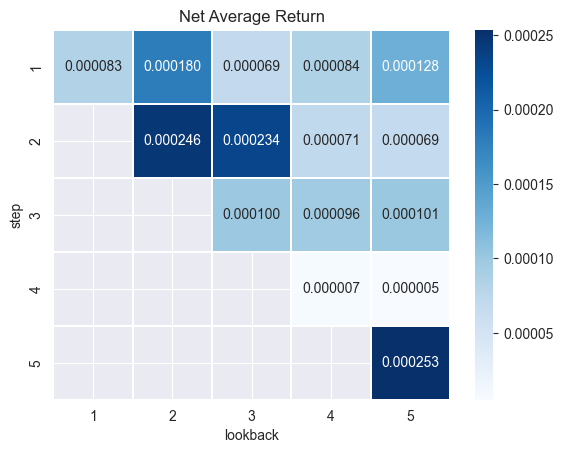

In [17]:
cv_results = cv_results.pivot(index='step', columns='lookback', values='score')
sns.heatmap(cv_results, annot=True, fmt='.6f', linewidths=.25, cmap='Blues')
plt.title('Net Average Return')
plt.show()

Here we can see a 2 period step interval with a maximum look back of 2 periods performs the best. In the next notebook, we will adjust the parameters of the models

BONUS: Back test best parameters

In [19]:
# !pip3 install backtesting
from backtesting import Strategy, Backtest
from sklearn.model_selection import train_test_split

/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [21]:
step = 2
lookback = 2

spy = yf.download('SPY', start='2004-01-01')
agg = yf.download('AGG', start='2004-01-01')

spy = create_target(spy, lookforward, target='Open')

spy = features(spy, lookback, step)
spy = spy.add_suffix(' SPY')
agg = features(agg, lookback, step)
agg = agg.add_suffix(' AGG')
cv = pd.merge(spy, agg, how='inner', on='Date')

cv.drop(cv.tail(lookforward).index, inplace=True)
cv.drop(cv.head(max(lookbacks)).index, inplace=True)
X = cv
y = X[['Target SPY']]
X = X.drop(columns=['Target SPY'])
X.fillna(method="ffill", inplace=True)
X.replace([np.inf, -np.inf], 0, inplace=True)
X.fillna(0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, shuffle=False)
X_test = X_test.iloc[(abs(lookforward)):]
y_test = y_test.iloc[(abs(lookforward)):]

estimator.fit(X_train, y_train)
forecasted = estimator.predict(X_test)

data = yf.download('SPY', start='2004-01-01')
data.drop(data.tail(lookforward).index,inplace=True)
data.drop(data.head(lookback).index,inplace=True)
data = data.iloc[(-X_test.shape[0]):]
data['forecastedValue'] = forecasted
prediction = data

class MyStrategy(Strategy):
    Data = prediction

    def init(self):
        super().init()

    def next(self):
        if self.data.forecastedValue < 0:
            self.sell()
        elif self.data.forecastedValue > 0:
            self.buy()


bt = Backtest(prediction, MyStrategy,
              cash=1000,
              trade_on_close=False,
              exclusive_orders=True
              )
print(bt.run())
bt.plot(show_legend=False)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_75058/1076261055.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method="ffill", inplace=True)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[*********************100%%**********************]  1 of 1 completed
Start                     2021-01-06 00:00:00
End                       2024-01-03 00:00:00
Duration                   1092 days 00:00:00
Exposure Time [%]                   99.734396
Equity Final [$]                   1267.55014
Equity Peak [$]                   1311.299652
Return [%]                          26.755014
Buy & Hold Return [%]               25.495924
Return (Ann.) [%]                    8.257615
Volatility (Ann.) [%]               14.993779
Sharpe Ratio                         0.550736
Sortino Ratio                        0.881424
Calmar Ratio                         0.541839
Max. Drawdown [%]                  -15.239979
Avg. Drawdown [%]                    -2.98462
Max. Drawdown Duration      304 days 00:00:00
Avg. Drawdown Duration       43 days 00:00:00
# Trades                                  751
Win Rate [%]                        53.129161
Best Trade [%]                       5.538214
Worst Trade

/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_75058/1076261055.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['forecastedValue'] = forecasted
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/opt/homebrew/Caskroom/miniforge/base/envs/py3

GridPlot(id='p1606', ...)

Before we evaluate the results, one thing to mention is that the result from this back test is cheating a little bit, since we evaluated this data when we used TimeSeriesSplit. In order to make sure what we have is a real strategy, we need to remove the amount we are going to back test first, lets say 15%, and then cross validate using TimeSeriesSplit with the rest 85%, this way, our model has no way to cheat since it hasn't seen the last 15%.

Onto the results, they seem to be great, but like we pointed out before, the model cheated a little bit, so in the next notebook we will take that into account and test it again after we optimize the parameters on the models and see how well it performs then.